<a href="https://colab.research.google.com/github/chinezilian/Analise-de-Autoria-do-livro-de-Hebreus/blob/main/An%C3%A1lise_da_autoria_de_Hebreus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise da autoria  do livro de Hebreus

Foi feita uma classificação dos textos do livro de Hebreus relacionados a autores dos outros livros do Novo Testamento: Mateus, Marcos, Lucas, João, Paulo, Tiago, Pedro, Judas.  

In [1]:
!pip install -U spacy==3.2
!python -m spacy download el_core_news_lg
!pip install sklearn
!pip install bert-for-tf2

     |████████████████████████████████| 6.0 MB 5.3 MB/s 
     |████████████████████████████████| 10.1 MB 22.6 MB/s 
     |████████████████████████████████| 181 kB 35.1 MB/s 
     |████████████████████████████████| 451 kB 13.9 MB/s 
     |████████████████████████████████| 653 kB 21.2 MB/s 
     |████████████████████████████████| 42 kB 790 kB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 569.8 

In [2]:
import pandas as pd 
import gensim
from gensim import corpora,models
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer #tokenizes and counts words
from sklearn.feature_extraction.text import TfidfVectorizer #alternatively, use TfidfTransformer()
from sklearn import metrics
import requests
from sklearn.feature_selection import RFE, chi2
from scipy.spatial import distance
from pandas.core.frame import DataFrame
from nltk import FreqDist
from sklearn.metrics.pairwise import cosine_similarity
from gensim.matutils import kullback_leibler, jaccard, hellinger, sparse2full
import string
from scipy.stats import entropy
from numpy.linalg import norm
from scipy.spatial import distance
import spacy
from collections import Counter

from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from random import random
from numpy import array
from numpy import cumsum
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from tensorflow import keras
from tensorflow.keras import layers

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from spacy.tokenizer import Tokenizer
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
nltk.download('punkt')
import spacy
nltk.download('stopwords')
import re
from gensim.matutils import kullback_leibler, jaccard, hellinger, sparse2full
from scipy.stats import entropy
from numpy.linalg import norm
from scipy.spatial import distance
from spacy.lang.el import Greek
nlp = spacy.load('el_core_news_lg')
from spacy.lang.el import Greek

import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/My Drive/Dataset/na28withindex.csv"
df = pd.read_csv(dir, encoding = 'utf-16', sep = '\t')

Mounted at /content/drive


In [4]:
## transfer text to pos tag
def pos_tag(text):
    pos_tag = []
    for t in text['Verse_index']:
        pos_tag.append(t)
    for y in Heb['Verse_index']:
        pos_tag.append(y)
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(pos_tag)
    sequences_train = tokenizer.texts_to_sequences(pos_tag)
    word_index = tokenizer.word_index
    x_train = pad_sequences(sequences_train, maxlen=seq_length)
    return x_train

In [5]:
## create target variable
def text_author(text):
    author_tag = []
    for t in text['Author_index']:
        author_tag.append(t)
    for f in Heb['Author_index']:
        author_tag.append(f)
    my_array = np.array(author_tag)
    return my_array

In [6]:
## create target por livro
def text_book(df):
    x=0
    author_tag = []
    for livro in df.BookName.unique():
      df.Author_index[df.BookName == livro] = x
      x=x+1
    return df

In [7]:
# create target por livro
def text_autor(df):
    x=0
    author_tag = []
    for livro in df.Author.unique():
      df.Author_index[df.Author == livro] = x
      x=x+1
    return df

In [8]:
df1=df.loc[df["BookName"] != 'heb']

In [9]:
df2 = text_autor(df1)
df2

,BookName,ChapNum,VerNum,Verse,Author,Author_index,Verse_index
0,Mt,1,1,Βίβλος γενέσεως Ἰησοῦ Χριστοῦ υἱοῦ Δαυὶδ υἱοῦ ...,Matthew,0,"[101, 101, 96, 101, 92, 101, 96, 101, 97]"
1,Mt,1,2,"Ἀβραὰμ ἐγέννησεν τὸν Ἰσαάκ, Ἰσαὰκ δὲ ἐγέννησεν...",Matthew,0,"[101, 101, 101, 96, 97, 96, 85, 101, 101, 96, ..."
2,Mt,1,3,Ἰούδας δὲ ἐγέννησεν τὸν Φάρες καὶ τὸν Ζάρα ἐκ ...,Matthew,0,"[101, 85, 101, 90, 96, 89, 90, 101, 85, 90, 96..."
3,Mt,1,4,"Ἀρὰμ δὲ ἐγέννησεν τὸν Ἀμιναδάβ, Ἀμιναδὰβ δὲ ἐγ...",Matthew,0,"[86, 85, 101, 90, 96, 97, 96, 92, 101, 90, 101..."
4,Mt,1,5,"Σαλμὼν δὲ ἐγέννησεν τὸν Βόες ἐκ τῆς Ῥαχάβ, Βόε...",Matthew,0,"[96, 85, 101, 87, 101, 85, 90, 101, 97, 101, 8..."
...,...,...,...,...,...,...,...
7824,Offb,22,17,Καὶ τὸ πνεῦμα καὶ ἡ νύμφη λέγουσιν· ἔρχου. καὶ...,John,3,"[92, 90, 92, 89, 90, 101, 101, 97, 101, 97, 87..."
7825,Offb,22,18,Μαρτυρῶ ἐγὼ παντὶ τῷ ἀκούοντι τοὺς λόγους τῆς ...,John,3,"[101, 100, 100, 90, 92, 84, 92, 84, 92, 90, 92..."
7826,Offb,22,19,καὶ ἐάν τις ἀφέλῃ ἀπὸ τῶν λόγων τοῦ βιβλίου τῆ...,John,3,"[89, 90, 90, 86, 85, 90, 92, 90, 92, 90, 92, 9..."
7827,Offb,22,20,"Λέγει ὁ μαρτυρῶν ταῦτα· ναί, ἔρχομαι ταχύ. Ἀμή...",John,3,"[101, 90, 92, 95, 97, 92, 97, 100, 95, 101, 97..."


In [10]:
df2.Author.unique()

array(['Matthew', 'Mark', 'Luke', 'John', 'Paul', 'James', 'Peter',
       'Jude'], dtype=object)

In [11]:
Matthew = df[df.BookName == 'Mt']
Matthew['Author'] = 'Mateus'
Mark = df[df.BookName == 'Mc']
Mark['Author'] = 'Marcos'
Luke = df[df.BookName == 'Lc']
Luke['Author'] = 'Lucas'
John = df[df.BookName == 'Jo']
John['Author'] = 'Joao'
Acts = df[df.BookName == 'At']
Acts['Author'] = 'Lucas'
Luke_Book = pd.concat([Luke,Acts],axis = 0)
James = df[df.BookName == 'Tg']
James['Author'] = 'Tiago'
f_Peter = df[df.BookName == '1Pe']
s_Peter = df[df.BookName == '2Pe']
f_Peter['Author'] = 'Pedro'
s_Peter['Author'] = 'Pedro'
Peter_letter = pd.concat([f_Peter, s_Peter], axis = 0)

f_John = df[df.BookName == '1Jo']
s_John = df[df.BookName == '2Jo']
t_John = df[df.BookName == '3Jo']
f_John['Author'] = 'Joao'
s_John['Author'] = 'Joao'
t_John['Author'] = 'Joao'
John_letter = pd.concat([f_John, s_John, t_John], axis = 0)

Jude = df[df.BookName == 'Jud']
Jude['Author'] = 'Judas'
Rev = df[df.BookName == 'Apoc']
Rev['Author'] = 'Joao'
John_Book = pd.concat([John,John_letter,Rev],axis = 0)

In [12]:
Romans = df[df.BookName == 'Rom']
Romans['Author'] = 'Paulo'
f_cor = df[df.BookName == '1Cor']
f_cor['Author'] = 'Paulo'
s_cor = df[df.BookName == '2Cor']
s_cor['Author'] = 'Paulo'
Gal = df[df.BookName == 'Gal']
Gal['Author'] = 'Paulo'
Eph = df[df.BookName == 'Ef']
Eph['Author'] = 'Paulo'
Phi = df[df.BookName == 'Fil']
Phi['Author'] = 'Paulo'
Col = df[df.BookName == 'Col']
Col['Author'] = 'Paulo'
f_the = df[df.BookName == '1Tess']
f_the['Author'] = 'Paulo'
s_the = df[df.BookName == '2Tess']
s_the['Author'] = 'Paulo'
f_tim = df[df.BookName == '1Tim']
f_tim['Author'] = 'Paulo'
s_tim = df[df.BookName == '2Tim']
s_tim['Author'] = 'Paulo'
Titus = df[df.BookName == 'Tit']
Titus['Author'] = 'Paulo'
Philemon = df[df.BookName == 'Flm']
Philemon['Author'] = 'Paulo'
Paul_letters = pd.concat([Romans,f_cor,s_cor,Gal,Eph,Phi,Col,f_the,s_the,f_tim,s_tim,Titus,Philemon],axis = 0)


In [13]:
# X_train, X_test, y_train, y_test = train_test_split(rnntext, rnntext2, test_size = 0.2)

In [14]:
!rm -rf bert-base-greek-uncased-v1
!mkdir bert-base-greek-uncased-v1
!wget https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-greek-uncased-v1/bert-base-greek-uncased-v1_pytorch_checkpoint.zip
!wget https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-greek-uncased-v1/vocab.txt 

!apt-get install unzip

!unzip bert-base-greek-uncased-v1_pytorch_checkpoint.zip -d bert-base-greek-uncased-v1
!mv vocab.txt bert-base-greek-uncased-v1/vocab.txt 
!pip install -U transformers

--2022-03-23 19:07:15--  https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-greek-uncased-v1/bert-base-greek-uncased-v1_pytorch_checkpoint.zip
Resolving neuralmind-ai.s3.us-east-2.amazonaws.com (neuralmind-ai.s3.us-east-2.amazonaws.com)... 52.219.104.136
Connecting to neuralmind-ai.s3.us-east-2.amazonaws.com (neuralmind-ai.s3.us-east-2.amazonaws.com)|52.219.104.136|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-03-23 19:07:16 ERROR 403: Forbidden.

--2022-03-23 19:07:16--  https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-greek-uncased-v1/vocab.txt
Resolving neuralmind-ai.s3.us-east-2.amazonaws.com (neuralmind-ai.s3.us-east-2.amazonaws.com)... 52.219.104.136
Connecting to neuralmind-ai.s3.us-east-2.amazonaws.com (neuralmind-ai.s3.us-east-2.amazonaws.com)|52.219.104.136|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-03-23 19:07:16 ERROR 403: Forbidden.

Reading package lists... Done
Building dependenc

In [15]:
from transformers import BertTokenizer, BertConfig, TFBertModel
bert_model = TFBertModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", from_pt=True)

Downloading:   0%|          | 0.00/459 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [16]:
# Functions for constructing BERT Embeddings: input_ids, input_masks, input_segments and Inputs
MAX_SEQ_LEN=500 # max sequence length
from transformers import AutoTokenizer

def get_masks(tokens):
    """Masks: 1 for real tokens and 0 for paddings"""
    return [1]*len(tokens) + [0] * (MAX_SEQ_LEN - len(tokens))
 
def get_segments(tokens):
    """Segments: 0 for the first sequence, 1 for the second"""  
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (MAX_SEQ_LEN - len(tokens))

def get_ids(tokens, tokenizer):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (MAX_SEQ_LEN - len(token_ids))
    return input_ids

def create_single_input(sentence, tokenizer, max_len):
    """Create an input from a sentence"""
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:max_len]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer)
    masks = get_masks(stokens)
    segments = get_segments(stokens)

    return ids, masks, segments
 
def convert_sentences_to_features(sentences, tokenizer):
    """Convert sentences to features: input_ids, input_masks and input_segments"""
    input_ids, input_masks, input_segments = [], [], []
 
    for sentence in tqdm(sentences,position=0, leave=True):
      ids,masks,segments=create_single_input(sentence,tokenizer,MAX_SEQ_LEN-2)
      assert len(ids) == MAX_SEQ_LEN
      assert len(masks) == MAX_SEQ_LEN
      assert len(segments) == MAX_SEQ_LEN
      input_ids.append(ids)
      input_masks.append(masks)
      input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

def create_tonkenizer(bert_layer):
    """Instantiate Tokenizer with vocab"""
    # vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
    # do_lower_case=bert_layer.resolved_object.do_lower_case.numpy() 
    # tokenizer=bert.bert_tokenization.FullTokenizer(vocab_file,do_lower_case)
    do_lower_case = False
    tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
    return tokenizer

In [ ]:
from keras.layers.convolutional import Conv1D  
def nlp_model(callable_object):
    # Load the pre-trained BERT base model
    # bert_layer = hub.KerasLayer(handle=callable_object, trainable=True)  

    bert_layer = callable_object
   
    # BERT layer three inputs: ids, masks and segments
    input_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_ids")           
    input_masks = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_masks")       
    input_segments = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")

    
    inputs = [input_ids, input_masks, input_segments] # BERT inputs
    # If using hub.KerasLayer, PLEASE, CHANGE THE ORDER of the variables, I mean: 
    # pooled_output, sequence_output = 
    # sequence_output, pooled_output = bert_layer(inputs) # BERT outputs 
    bert_output = bert_model(input_ids, attention_mask=input_masks, token_type_ids=input_segments)
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # # Add a hidden layer
    x = Dropout(0.5)(pooled_output)
    x = Dense(units=768, activation='relu')(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Add output layer
    outputs = Dense(8, activation="softmax")(x)

    # Construct a new model
    model = Model(inputs=inputs, outputs=outputs, )
    return model

In [ ]:
model = nlp_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 500)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  112921344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_masks[0][0]',        

In [ ]:
# Create examples for training and testing

df = df.sample(frac=1) # Shuffle the dataset
tokenizer = create_tonkenizer(model.layers[3])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df2['Verse'], df2['Author_index'], 
    test_size=0.3, 
    stratify=df2['Author_index'], 
    random_state=15 
    )

print( "\nx_train: {}; \tX_test: {}".format(X_train.shape, X_test.shape))
print("\ny_test: \n{}, \n\ny_train: \n{}".format(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True) ) )

X_train = convert_sentences_to_features(X_train, tokenizer)
X_test = convert_sentences_to_features(X_test, tokenizer)

y_train = to_categorical( y_train )
y_test =  to_categorical( y_test )

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]


x_train: (5282,); 	X_test: (2264,)

y_test: 
2    0.281522
4    0.265430
3    0.186861
0    0.139341
1    0.088035
6    0.021204
5    0.014388
7    0.003218
Name: Author_index, dtype: float64, 

y_train: 
2    0.281360
4    0.265459
3    0.186837
0    0.139134
1    0.088339
6    0.021201
5    0.014134
7    0.003534
Name: Author_index, dtype: float64


100%|██████████| 2264/2264 [00:01<00:00, 1442.99it/s]


In [ ]:
# callback

checkpoint_path = "./autor_model"
ckpt = tf.train.Checkpoint(model=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [ ]:
%%time
# Train the model
BATCH_SIZE = 8
EPOCHS = 2

# Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=1e-5)

# loss = tf.keras.losses.CategoricalCrossentropy()
# metric = tf.keras.metrics.CategoricalAccuracy()

#Fix BERT weight
# params = [p for n, p in model_params if not "bert" in n]
# optimizer = AdamW(params , lr=2e-5)

# #Release the weight fixing of BERT
# params = [p for n, p in model_params if "bert" in n]
# optimizer.add_param_group({'params': params })

# softmax_cross_entropy_with_logits
model.compile(optimizer=opt, 
              loss= 'categorical_crossentropy', #binary_crossentropy
              metrics = ['categorical_accuracy']
              )

# Fit the data to the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose = 1,
                    callbacks=[CustomCallback()]
                    )


Epoch 1/2
661/661 [==============================] - 1416s 2s/step - loss: 1.3446 - categorical_accuracy: 0.5382 - val_loss: 1.1562 - val_categorical_accuracy: 0.5866
Epoch 2/2
661/661 [==============================] - 1373s 2s/step - loss: 1.1526 - categorical_accuracy: 0.6066 - val_loss: 1.0259 - val_categorical_accuracy: 0.6515
CPU times: user 29min 38s, sys: 3min 23s, total: 33min 1s
Wall time: 46min 29s


In [ ]:
# !pip install -q pyyaml h5py
name = "verif_author"
model.save("{}.h5".format(name))

In [ ]:
print(classification_report(np.argmax(y_test,axis=1), pred_test))

In [17]:
# Carrega os modelo BERT
from tensorflow.keras.models import load_model
from transformers import BertTokenizer, BertConfig, TFBertModel
from transformers import logging

logging.set_verbosity_warning()
dir = "/content/drive/My Drive/Dataset/Sensory/sentiment-analisys/author.h5"

config = BertConfig()
new_model = load_model(dir ,custom_objects={'TFBertModel':TFBertModel(config)})


In [18]:
# Predict on test dataset
from sklearn.metrics import classification_report, confusion_matrix
# pred_test = np.argmax(new_model.predict(X_test, verbose=1), axis=1)

In [19]:
Heb = df[df.BookName == 'heb']
Heb['Author'] = '?'

In [20]:
tokenizer = create_tonkenizer(new_model.layers[3])
hebreus = convert_sentences_to_features(Heb['Verse'], tokenizer)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

100%|██████████| 283/283 [00:00<00:00, 1695.60it/s]


In [21]:
pred = np.argmax(new_model.predict(hebreus, verbose=1), axis=1)
livro=pd.DataFrame(pred, columns=['pred'])
dicio={0:'Mateus', 1:'Marcos', 2:'Lucas', 3:'João', 4:'Paulo', 5:'Tiago', 6:'Pedro',
       7:'Judas'}
livro['nome']=livro.pred.map(dicio)


9/9 [==============================] - 27s 2s/step


In [22]:
predicao=pd.DataFrame(livro.nome.value_counts())
predicao

,nome
Paulo,131
Lucas,115
Pedro,14
Mateus,11
João,7
Marcos,5


In [23]:
predicao['perc']=predicao.nome.apply(lambda x: round(x/len(pred)*100, 2))
predicao['%']=predicao.nome.apply(lambda x: str(round(x/len(pred)*100, 2))+'%')
predicao

,nome,perc,%
Paulo,131,46.29,46.29%
Lucas,115,40.64,40.64%
Pedro,14,4.95,4.95%
Mateus,11,3.89,3.89%
João,7,2.47,2.47%
Marcos,5,1.77,1.77%


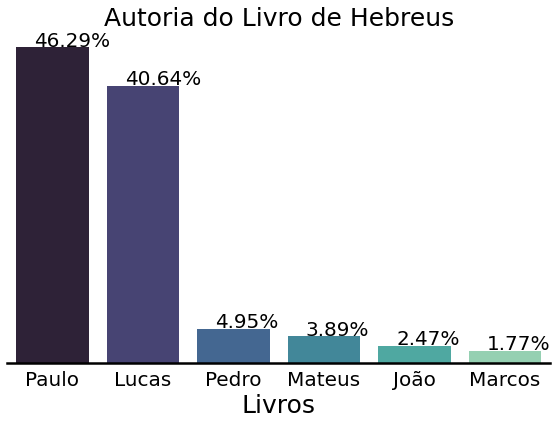

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

altura = []
for i in predicao['perc']:
   altura.append(i)
posicao = []
for i in range(0,6,1): 
   posicao.append(i)

#criando uma figure, axes, alterando tamanho
fig, ax = plt.subplots(figsize=(8,6))
# plt.figure(facecolor='#94F008')
#criando o gráfico de barras
sns.barplot(x=predicao.index, y=predicao['perc'], ax=ax, data=predicao,  palette='mako')
#adicionando título
ax.set_title("Autoria do Livro de Hebreus", fontdict={'fontsize':25})
#mudando e nome e tamanho do label x
ax.set_xlabel('Livros', fontdict={'fontsize':25})
#mudando tamanho do label eixo y
ax.set_ylabel('')
#mudando tamanho dos labels dos ticks
ax.tick_params(labelsize=20, 
           color='w')
#aumentando espessura linha inferior
ax.spines['bottom'].set_linewidth(2.5)

#remoção dos outros três axis
for axis in ['top', 'right', 'left']:
   ax.spines[axis].set_color('white')
#remoção dos ticks
ax.tick_params(axis='y', labelleft=False, left=None)
# ax.tick_params(axis='x', colors='w')                  
#Colocando a quantidade em cada barra
for i in range(6):
   ax.text(x=posicao[i]-0.2, y=altura[i]+0.2, s=str(altura[i])+'%',   
           fontsize=20)
plt.savefig('graph.png', format='png')
#otimizar espaço da figure
fig.tight_layout();
